In [36]:
# import module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import optuna
import plotly.express as px
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, SubsetRandomSampler, TensorDataset
from torchinfo import summary



In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')


Using cuda


In [19]:
# Define the model architecture as a sequence of linear layers, ReLU activations, and batch normalization
class Model(nn.Module):
    def __init__(self, input_dim, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4, num_hidden_5, output_dim):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, num_hidden_1),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_1),
                                   nn.Linear(num_hidden_1, num_hidden_2),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_2),
                                   nn.Linear(num_hidden_2, num_hidden_3),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_3),
                                   nn.Linear(num_hidden_3, num_hidden_4),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_4),
                                   nn.Linear(num_hidden_4, num_hidden_5),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_5),
                                   nn.Linear(num_hidden_5, num_hidden_4),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_4),
                                   nn.Linear(num_hidden_4, num_hidden_3),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_3),
                                   nn.Linear(num_hidden_3, num_hidden_2),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_hidden_2),
                                   nn.Linear(num_hidden_2, num_hidden_1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_hidden_1),
                                   nn.Linear(num_hidden_1, output_dim)
                                   )

    def forward(self, x):
        return self.model(x)


In [20]:
def train_epoch(model, dataloader, loss_fn, optimizer, device) -> float:
    num_batches = len(dataloader)
    train_loss = 0.0
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = loss_fn(output, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/num_batches


In [21]:
def valid_epoch(model, dataloader, loss_fn, device) -> float:
    num_batches = len(dataloader)
    valid_loss = 0.0
    model.eval()
    with torch.inference_mode(mode=True):
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = loss_fn(output, y)
            valid_loss += loss.item()
    return valid_loss/num_batches


In [22]:
def train(model, train_loader, valid_loader, loss_fn, optimizer, epochs, device):

    result = defaultdict(list)

    model.to(device)

    for epoch in tqdm(range(1, epochs + 1)):

        train_loss = train_epoch(
            model, train_loader, loss_fn, optimizer, device)
        valid_loss = valid_epoch(model, valid_loader, loss_fn, device)
        result['train_loss'].append(train_loss)
        result['valid_loss'].append(valid_loss)
    return result


In [23]:
def plot(result):
    epochs = range(len(result['train_loss']))
    plt.figure()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(epochs, result['train_loss'], label='train_loss')
    plt.plot(epochs, result['valid_loss'], label='valid_loss')
    plt.legend()
    plt.show()


In [24]:
K = 5
EPOCHS = 400
BATCH_SIZE = 128

params = {'input_dim': 2, 'num_hidden_1': 16, 'num_hidden_2': 32,
          'num_hidden_3': 64, 'num_hidden_4': 128, 'num_hidden_5': 256, 'output_dim': 1}


In [25]:
df = pd.read_csv('data/train.csv')
x = torch.tensor(df.drop(['id', 'y'], axis=1).values,
                 dtype=torch.float32).view(-1, 2)
y = torch.tensor(df['y'].values, dtype=torch.float32).view(-1, 1)
train_data = TensorDataset(x, y)


In [26]:
def objective(trial):
    model = Model(**params).to(device)

    optimizer_name = trial.suggest_categorical(
        'optimizer', ['SGD', 'AdamW'])  # 'Adam',
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    wd = trial.suggest_float('wd', 1e-2, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(
        model.parameters(), lr=lr, weight_decay=wd)
    loss_fn_name = trial.suggest_categorical(
        'criterion', ['MSELoss', 'HuberLoss'])
    criterion = getattr(nn, loss_fn_name)(reduction='mean')

    train_set, valid_set = random_split(train_data, [0.7, 0.3])
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
    valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

    model.train()
    for epoch in range(EPOCHS):
        for batch, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs.reshape(-1), y.reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    losses = []
    with torch.no_grad():
        for batch, (x, y) in enumerate(valid_loader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs.reshape(-1), y.reshape(-1))
            losses.append(loss.item())

    loss = sum(losses)/len(losses)
    return loss


In [27]:
# Creating Optuna object and defining its parameters
study = optuna.create_study(
    direction='minimize', study_name='FunApprox', storage='sqlite:///model.db')
study.optimize(objective, n_trials=30)
df_study = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
# Showing results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)


[I 2023-05-05 14:51:56,607] A new study created in RDB with name: FunApprox
[I 2023-05-05 14:52:57,175] Trial 0 finished with value: 0.05332029414804358 and parameters: {'optimizer': 'SGD', 'lr': 0.008279740759249015, 'wd': 0.07194214965789966, 'criterion': 'MSELoss'}. Best is trial 0 with value: 0.05332029414804358.
[I 2023-05-05 14:54:04,760] Trial 1 finished with value: 0.018454113288929586 and parameters: {'optimizer': 'AdamW', 'lr': 0.0010528007232513418, 'wd': 0.07976932183269499, 'criterion': 'HuberLoss'}. Best is trial 1 with value: 0.018454113288929586.
[I 2023-05-05 14:55:12,476] Trial 2 finished with value: 0.01973484231061057 and parameters: {'optimizer': 'AdamW', 'lr': 0.009024313884732807, 'wd': 0.012586972465889053, 'criterion': 'HuberLoss'}. Best is trial 1 with value: 0.018454113288929586.
[I 2023-05-05 14:56:12,542] Trial 3 finished with value: 0.10786054361807673 and parameters: {'optimizer': 'SGD', 'lr': 4.656643318893019e-05, 'wd': 0.049051124629386454, 'criterion'

Number of finished trials: 30
Best trial parameters: {'criterion': 'HuberLoss', 'lr': 0.0004251525892528786, 'optimizer': 'AdamW', 'wd': 0.06528892052086577}
Best score: 0.01672237405651494


In [28]:
df_study


,number,value,params_criterion,params_lr,params_optimizer,params_wd,state
0,0,0.053320,MSELoss,0.008280,SGD,0.071942,COMPLETE
1,1,0.018454,HuberLoss,0.001053,AdamW,0.079769,COMPLETE
2,2,0.019735,HuberLoss,0.009024,AdamW,0.012587,COMPLETE
3,3,0.107861,HuberLoss,0.000047,SGD,0.049051,COMPLETE
4,4,0.095938,MSELoss,0.004052,SGD,0.053766,COMPLETE
5,5,0.275194,MSELoss,0.000013,SGD,0.013551,COMPLETE
6,6,0.021626,HuberLoss,0.008804,AdamW,0.068471,COMPLETE
7,7,0.523900,HuberLoss,0.000011,SGD,0.048123,COMPLETE
8,8,0.085701,HuberLoss,0.000039,SGD,0.024002,COMPLETE
9,9,0.017503,HuberLoss,0.000346,AdamW,0.093768,COMPLETE


  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 1 Train loss: 0.013173692878335714 Valid loss: 0.013571361581293436


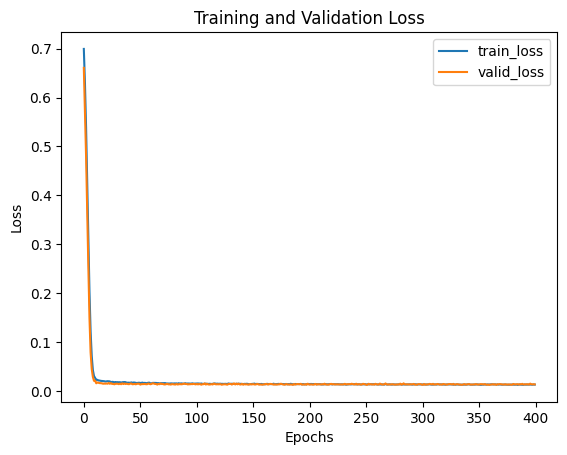

  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 2 Train loss: 0.013110862895846367 Valid loss: 0.012906900965250455


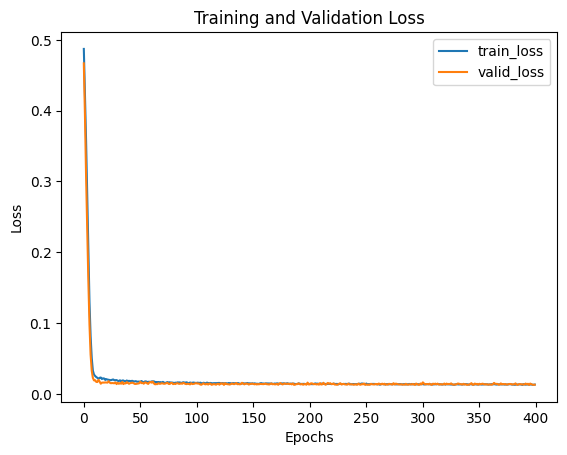

  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 3 Train loss: 0.013311652112752198 Valid loss: 0.013638724787877156


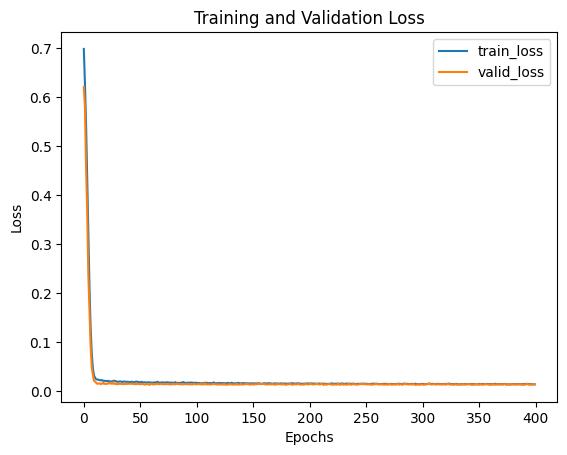

  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 4 Train loss: 0.013128069136291743 Valid loss: 0.013835004530847073


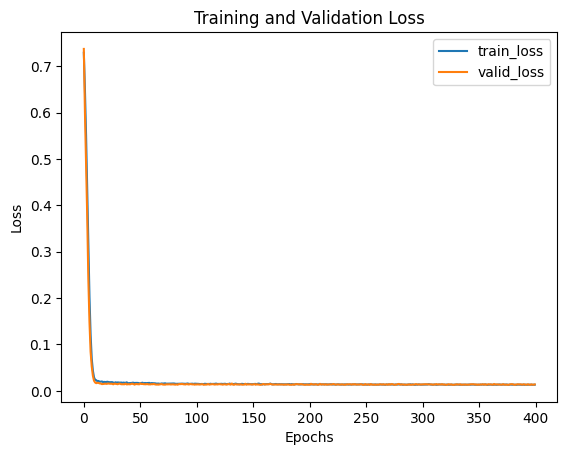

  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 5 Train loss: 0.013413416426628829 Valid loss: 0.01290077673128018


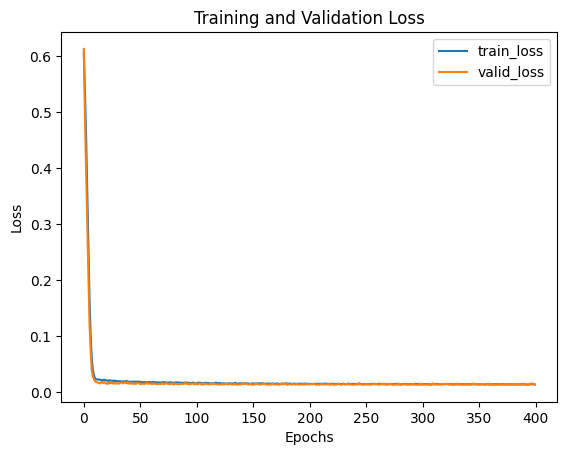

In [29]:

models = []
kfold = KFold(n_splits=K)

for fold_i, (train_idx, val_idx) in enumerate(kfold.split(train_data)):
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(
        train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
    valid_loader = DataLoader(
        train_data, batch_size=BATCH_SIZE, sampler=valid_sampler)

    model = Model(**params)
    loss_fn = getattr(nn, study.best_params['criterion'])(reduction='mean')

    optimizer = getattr(optim, study.best_params['optimizer'])(model.parameters(
    ), lr=study.best_params['lr'], weight_decay=study.best_params['wd'])

    result = train(model, train_loader, valid_loader, loss_fn,
                   optimizer, EPOCHS, device)
    print(
        f"KFold: {fold_i+1} Train loss: {result['train_loss'][-1]} Valid loss: {result['valid_loss'][-1]}")
    models.append(model.state_dict())
    plot(result)


In [30]:
test_data = pd.read_csv('data/test.csv')
test_x = torch.tensor(test_data.drop(
    ['id'], axis=1).values, dtype=torch.float32).view(-1, 2).to(device)

model = Model(**params).to(device)
outputs = np.zeros(len(test_x))

for model_i in models:

    model.load_state_dict(model_i)
    model.eval()

    outputs += model(test_x).cpu().detach().numpy().flatten()

outputs /= len(models)

submission = pd.DataFrame({'id': range(1, len(outputs) + 1), 'y': outputs})

submission.to_csv('./submission.csv', index=False)


In [31]:
best = pd.read_csv('my_submission.csv')

best = best['y'].values
print(np.mean((outputs - best) ** 2))


0.0016475134415013344


In [37]:
model = Model(**params)
summary(model, input_size=(6400, 2))

c:\Users\River\anaconda3\envs\pytorch\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\River\anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [6400, 1]                 --
├─Sequential: 1-1                        [6400, 1]                 --
│    └─Linear: 2-1                       [6400, 16]                48
│    └─ReLU: 2-2                         [6400, 16]                --
│    └─BatchNorm1d: 2-3                  [6400, 16]                32
│    └─Linear: 2-4                       [6400, 32]                544
│    └─ReLU: 2-5                         [6400, 32]                --
│    └─BatchNorm1d: 2-6                  [6400, 32]                64
│    └─Linear: 2-7                       [6400, 64]                2,112
│    └─ReLU: 2-8                         [6400, 64]                --
│    └─BatchNorm1d: 2-9                  [6400, 64]                128
│    └─Linear: 2-10                      [6400, 128]               8,320
│    └─ReLU: 2-11                        [6400, 128]               --
│    └─